# Setup

In [ ]:
%%capture
%pip install poetry
%pip install git+https://github.com/oughtinc/ergo.git@9708efe4b6f887f6764cd1445828df1a8ea0820a
%pip install xlrd

In [ ]:
%load_ext google.colab.data_table

In [1]:
%%capture
import ergo
import numpy as np
import pandas as pd
import ssl
import math
import datetime
import warnings
import functools
from datetime import timedelta, date
from ergo.contrib.el_paso import *

In [2]:
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(module="plotnine", action="ignore")
warnings.filterwarnings(module="jax", action="ignore")
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
metaculus = ergo.Metaculus(
    username="oughtpublic", 
    password="123456",
    api_domain = "pandemic"
)

# Ergo extensions

We'll define some helper functions that might get moved into Ergo in the future.

In [4]:
START_DATE = date(2020, 4, 1)


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

        
# Rejection sampling

def rejection_sample(fn, condition):
    """
    Sample from fn until we get a value that satisfies
    condition, then return it.
    """
    while True:        
        value = fn()
        if condition(value):
            return value

        
# Associate models with questions

# We'll add a sampler here for each question we predict on. 
# Each sampler is a function that returns a single sample
# from our model predicting on that question.
samplers = {}

def question(question_id, community_weight=0, community_fn=None):
    q = metaculus.get_question(question_id)

    def decorator(func):
        tag = func.__name__

        @functools.wraps(func)
        @ergo.mem
        def sampler():
            if ergo.flip(community_weight):
                if community_fn:
                    value = community_fn()
                else:
                    value = q.sample_community()
            else:
                value = func()
            if isinstance(value, date):
                # FIXME: Ergo needs to handle dates
                ergo.tag(int((value - START_DATE).days), tag)
            else:
                ergo.tag(value, tag)
            return value
        sampler.question = q
        samplers[q.id] = sampler
        return sampler
    return decorator

def summarize_question_samples(samples):
    sampler_tags = [sampler.__name__ for sampler in samplers.values()]
    tags_to_show = [tag for tag in sampler_tags if tag in samples.columns]
    samples_to_show = samples[tags_to_show]
    summary = samples_to_show.describe().transpose().round(2)
    display(summary)

def plot_question(sampler, num_samples=200, bw=None):
    samples = ergo.run(sampler, num_samples=num_samples)

    summarize_question_samples(samples)

    q = sampler.question

    q_samples = samples[sampler.__name__]

    if q.id == 4128: # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
        q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])

    if bw is not None:
        q.show_prediction(samples=q_samples, show_community=True, percent_kept=0.9, bw=bw)
    else:
        q.show_prediction(samples=q_samples, show_community=True, percent_kept=0.9)

# External data (cases, estimates, models)

## Texas government cases data

In [5]:
el_paso_cases = texas_data.get_el_paso_data()

el_paso_cases

,Cases so far,New cases
2020-03-04,0,NaN
2020-03-05,0,0
2020-03-06,0,0
2020-03-09,0,0
2020-03-10,0,0
2020-03-11,0,0
2020-03-12,0,0
2020-03-13,0,0
2020-03-15,1,1
2020-03-16,1,0


## @onlyasith's cases model



Pulled [here](https://docs.google.com/spreadsheets/d/1L6pzFAEJ6MfnUwt-ea6tetKyvdi0YubnK_70SGm436c/edit#gid=1807978187)

In [43]:
projected_cases = onlyasith.get_onlyasith_results()

projected_cases

,Cases so far,New cases
Date,,
2020-04-04,96,NaN
2020-04-05,106,10.0
2020-04-06,115,9.0
2020-04-07,125,10.0
2020-04-08,153,28.0
...,...,...
2020-09-30,1090,0.0
2020-10-01,1090,0.0
2020-10-02,1091,1.0


## @KrisMoore's compiled data

Pulled [here](https://docs.google.com/spreadsheets/d/1eGF9xYmDmvAkr-dCmd-N4efHzPyYEfVl0YmL9zBvH9Q/edit#gid=1694267458).

In [7]:
compiled_data = krismoore.get_krismoore_data()

compiled_data

,cases,new_cases,2_day_sma_new_cases,presumed_active_cases,fatalities,recovered,In hospital confirmed,in_icu,on_ventilator,tests_el_paso_dpt_public_health_only,new_tests_el_paso_dpt_public_health_only,tests_el_paso_inc_other_labs,tests_texas_all_sources,population
date,,,,,,,,,,,,,,
2020-03-04,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"952,366"
2020-03-05,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## @brachbach model (cases -> hospitalized)

In [8]:
get_daily_hospital_confirmed = brachbach.get_daily_hospital_confirmed

# Model components

In [9]:
def get_historical_data(date: date, column_name):
    """
    Look up the value of a parameter on a given date
    in the historical data we've loaded.
    
    Return the value or raise a KeyError if we don't have it.
    """
    
    # prefer Texas government data over @KrisMoore compiled data
    try: 
        value = el_paso_cases.loc[date, column_name]
        if np.isnan(value):
            raise KeyError(f"value for {column_name} in el_paso_cases is NaN")
    except KeyError:
        value = compiled_data.loc[date, column_name]
        if np.isnan(value):
            raise KeyError(f"value for {column_name} in compiled_data is NaN")
    return value

@ergo.mem
def daily_infections(date: date) -> int:
    """
    What is the number of reported (new) Covid-19 infections on [date]?
    """
    try:
        # Look up Texas Government data
        new_cases = el_paso_cases.loc[date, "New cases"]
        if np.isnan(new_cases):
            raise KeyError
        return new_cases
    except KeyError:
        try:
            # Look up projections from @onlyasith's model
            cases = projected_cases.loc[date, "New cases"]
            if np.isnan(cases):
                raise KeyError
            
            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            # We're beyond the time range for data and model
            return 0

@ergo.mem
def mean_infections(start_date: date, end_date: date):
    """
    What is the average number of reported new infections for this range of 
    dates? (Including start date, excluding end date)
    """
    days = daterange(start_date, end_date)
    return np.mean([daily_infections(day) for day in days])

@ergo.mem
def sma_infections(date: date):
    """
    The simple moving average of infections for a date.
    
    Defined in https://pandemic.metaculus.com/questions/4128:
    
    'The 2-day SMA is defined as the unweighted average (arithmetic mean)
    over the current day and the previous day.'
    """
    return mean_infections(date - timedelta(1), date + timedelta(1))

# Build @brachbach model
hospital_confirmed_from_daily_infected_model = get_daily_hospital_confirmed(compiled_data, daily_infections)

@ergo.mem
def hospital_confirmed_for_date(date: date) -> int:
    """
    The total number of lab-confirmed COVID-19 patients in El Paso County in
    the hospital on this date
    """
    try:
        # Look up in-hospital confirmed cases from @KrisMoore's compiled data
        new_hospital_confirmed = compiled_data.loc[date, "In hospital confirmed"]
        if np.isnan(new_hospital_confirmed):
            raise KeyError
        return new_hospital_confirmed
    except KeyError:
        try:
            # Get point estimate from @brachbach's regression model
            cases = hospital_confirmed_from_daily_infected_model(date)
            
            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            return 0

@ergo.mem
def frac_icu_ventilation():
    """
    Proportion of ICU admissions requiring ventilation

    Approach (PabloStafforini et al): 
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO: 
    - Improve how we use case data
    - Add qualitative adjustments
    """
    ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
    icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
    return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)

@ergo.mem
def peak_compatible_with_historical_data(peak_date):
    if not peak_date in el_paso_cases.index:
        return True
    for comparison_date in daterange(START_DATE, peak_date + timedelta(11)):
        if comparison_date not in el_paso_cases.index:
            continue
        if sma_infections(comparison_date) > sma_infections(peak_date):
            return False
        if sma_infections(comparison_date) == sma_infections(peak_date) and comparison_date > peak_date:
            return False
    return True

# El Paso questions

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,32.21,23.62,25.0,25.0,25.0,25.0,155.0


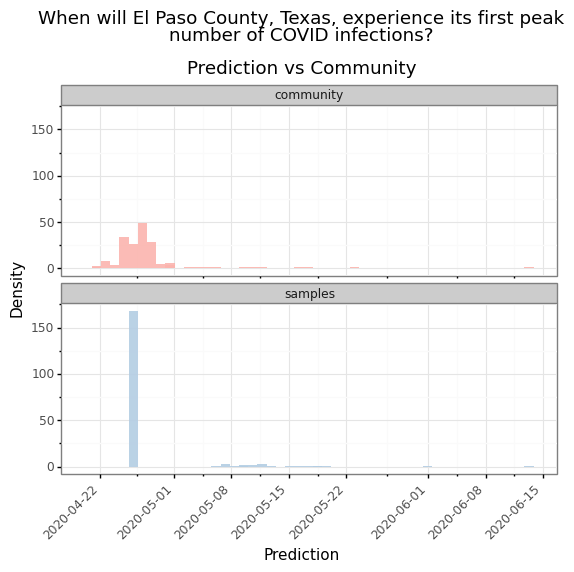

In [10]:
@ergo.mem
def peak_infection_date_community():
    """
    The community assigns probability to some dates in the past
    that we already know were not the peak.
    So instead of sampling from the full community distribution,
    sample from the portion of the community distribution
    that is plausibly correct.
    """    
    peak_date = rejection_sample(
        peak_infection_date.question.sample_community, 
        peak_compatible_with_historical_data)
    return peak_date


@question(4128, community_weight=0.5, community_fn=peak_infection_date_community)
def peak_infection_date() -> date:
    """
    When will El Paso County, Texas, experience its first peak number of COVID
    infections?
    
    From https://pandemic.metaculus.com/questions/4128:
    'This question resolves as the date for which
    the 2-day simple moving average(SMA) of the number of reported new infections
    is strictly greater than the 2-day SMA over the subsequent 10 days.'
    """
    end_date = date(2020, 7, 1)
    for today in daterange(START_DATE, end_date):
        sma_today = sma_infections(today)
        future_smas = [sma_infections(today + timedelta(i)) for i in range(1,11)]
        if sma_today > max(future_smas):
            return today
    return end_date

plot_question(peak_infection_date)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,103.0,31.50,22.34,25.0,25.00,25.0,25.00,147.00
peak_infections,200.0,103.82,400.89,0.0,72.34,74.0,74.61,5620.22


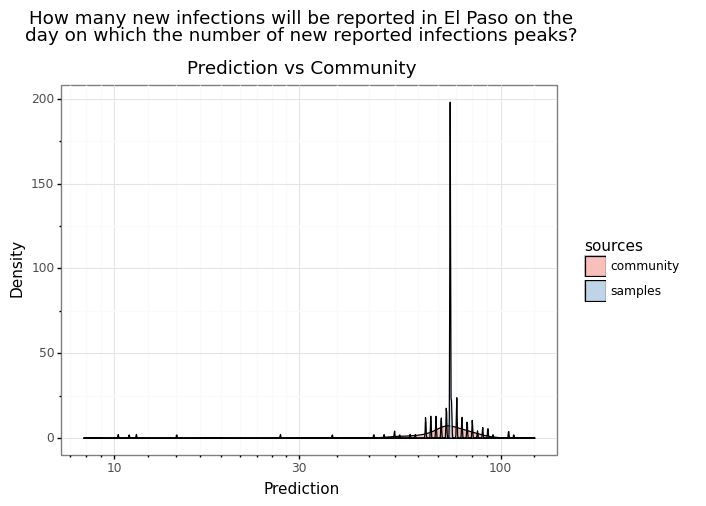

In [11]:
@question(4137, community_weight=0.5)
def peak_infections():
    """
    How many new infections will be reported in El Paso on the day on which
    the number of new reported infections peaks?
    """
    peak = peak_infection_date()
    return daily_infections(peak)

plot_question(peak_infections)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,86.0,32.31,23.36,25.0,25.00,25.00,25.0,143.00
mean_infections_peak345,200.0,52.57,281.16,0.0,27.63,31.67,31.7,3985.65


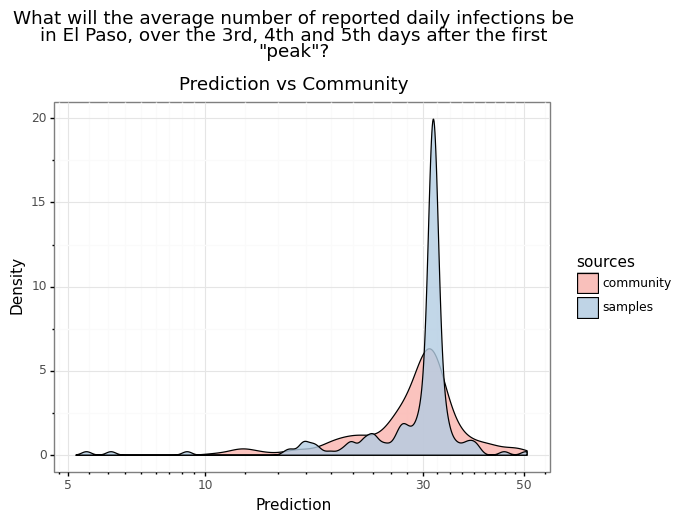

In [12]:
@question(4152, community_weight=0.5)
def mean_infections_peak345():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 3rd, 4th and 5th days after the first "peak"?
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(3), peak + timedelta(6))

plot_question(mean_infections_peak345)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,41.0,32.32,23.94,25.0,25.00,25.00,25.00,151.00
mean_infections_peak678,200.0,77.33,449.52,0.0,20.43,24.67,27.63,5006.34


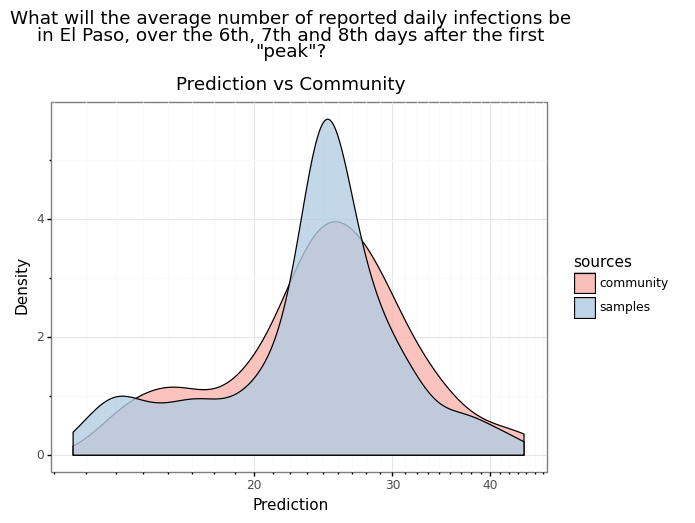

In [13]:
@question(4170, community_weight=0.8)
def mean_infections_peak678():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 6th, 7th and 8th days after the first "peak"?  
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(6), peak + timedelta(9))

plot_question(mean_infections_peak678)

,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,200.0,0.29,0.1,0.05,0.22,0.28,0.36,0.73


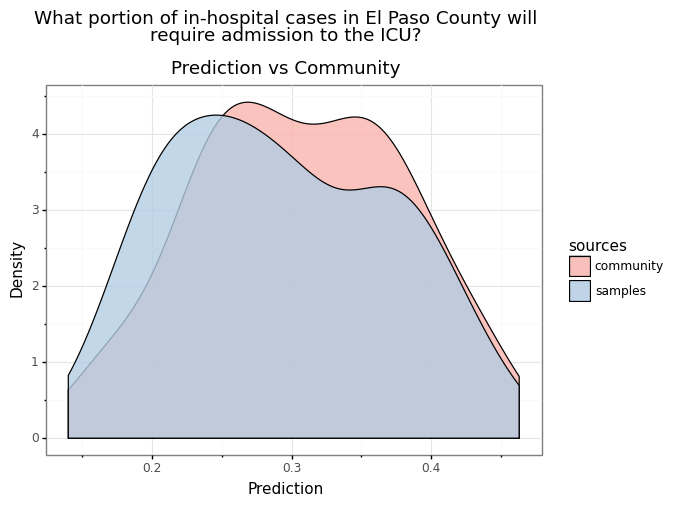

In [14]:
@question(4155, community_weight=0.7)
def frac_patients_icu():
    """
    What portion of in-hospital cases in El Paso County will require admission
    to the ICU?

    Following @katifish's approach:
    https://pandemic.metaculus.com/questions/4155/#comment-28054

    TODO: Add others from katifish comment
    """
    alpha = 0.1 # Rescaling counts becase we're more uncertain than implied by counts
    return ergo.random_choice([
      ergo.beta_from_hits(alpha * 121, alpha * 508),
      ergo.beta_from_hits(alpha * 181, alpha * 507),
    ])

plot_question(frac_patients_icu)

,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,136.0,0.29,0.10,0.0,0.23,0.30,0.35,0.56
frac_patients_invasive,200.0,0.15,0.05,0.0,0.12,0.15,0.19,0.30


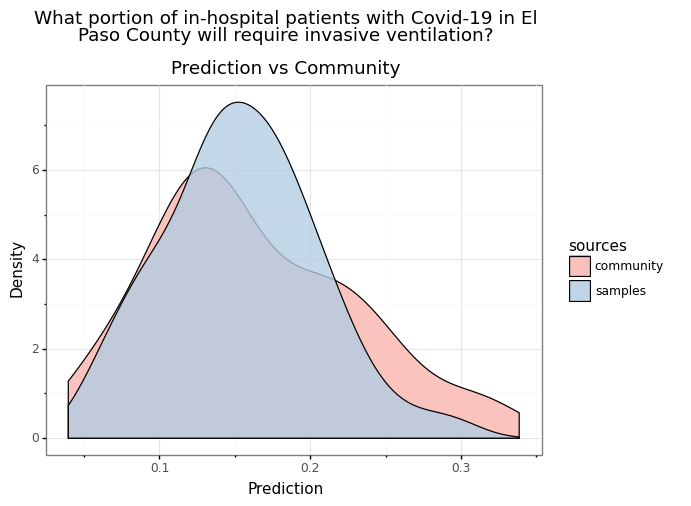

In [15]:
@question(4154, community_weight=0.3)
def frac_patients_invasive():
    """
    What portion of in-hospital patients with Covid-19 in El Paso County will
    require invasive ventilation?

    Following @PabloStafforini's indirect estimation approach:
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO:
    - Combine with direct estimate
      direct_estimate = ergo.beta_from_hits(0.1 * 130, 0.1 * 393)
    """
    return frac_patients_icu() * frac_icu_ventilation()

plot_question(frac_patients_invasive)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,138.0,33.86,24.70,25.00,25.0,25.0,25.0,158.00
max_30d_hospital_confirmed_for_peak,200.0,84.14,230.79,1.18,65.0,65.0,65.0,2367.43


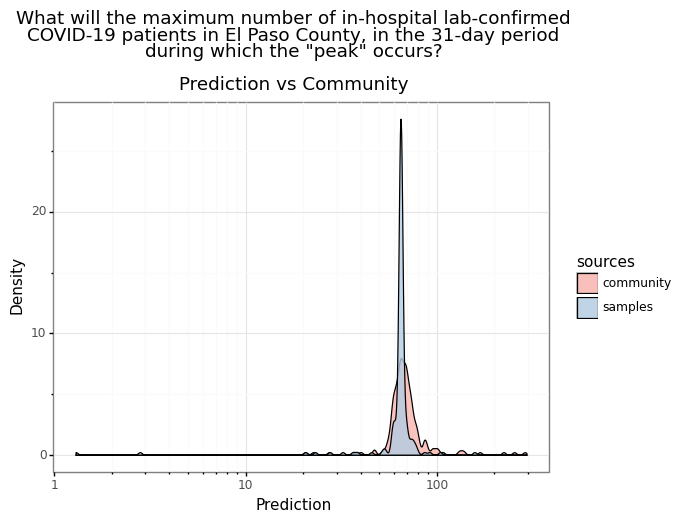

In [48]:
@ergo.mem
def peak_hospitalized_date():
    """
    What will be the date when there are the max number of COVID patients in the hospital
    within 15 days before or after the date of the first peak in confirmed cases?
    """
    infection_peak_date = peak_infection_date()
    days = list(daterange(infection_peak_date - timedelta(15), infection_peak_date + timedelta(16)))
    
    hospitalization_peak_date = days[0]
    hospitalized_peak = 0
    
    for day in days:
        hospitalized_for_day = hospital_confirmed_for_date(day)
        
        # if there are 2 different dates
        # with the same peak number of hospitalized patients,
        # return the first date:
        # https://pandemic.metaculus.com/questions/4204#comment-30023
        if hospitalized_for_day > hospitalized_peak:
            hospitalization_peak_date = day
            hospitalized_peak = hospitalized_for_day
    
    return hospitalization_peak_date

@question(4153, community_weight=0.3)
def max_30d_hospital_confirmed_for_peak():
    """
    What will the maximum number of in-hospital lab-confirmed COVID-19 
    patients in El Paso County, in the 30-day period during which the "peak"
    occurs?
    """
    return hospital_confirmed_for_date(peak_hospitalized_date())

plot_question(max_30d_hospital_confirmed_for_peak, bw=0.01)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,34.82,27.71,25.00,25.00,25.00,25.00,160.00
frac_patients_icu,5.0,0.28,0.10,0.13,0.26,0.28,0.35,0.38
max_30d_hospital_confirmed_for_peak,5.0,36.90,32.26,1.26,8.49,36.34,69.19,69.19
peak_icu_patients,200.0,27.38,5.53,0.48,27.00,27.00,27.00,51.75


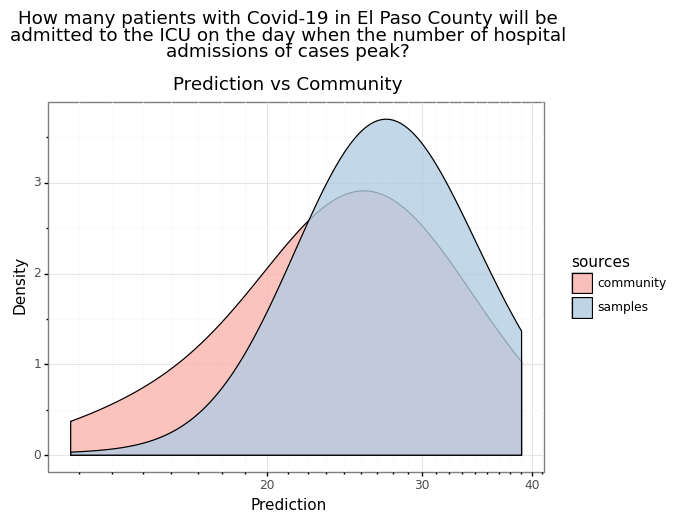

In [51]:
@question(4204)
def peak_icu_patients():
    """
    How many patients with Covid-19 in El Paso County will be in the
    ICU on the day when the number of hospital admissions of cases peak? 
    """
    try:
        return get_historical_data(peak_hospitalized_date(), "in_icu")
    except KeyError:
        # If we don't have historical data,
        # use the community prediction...
        if ergo.flip(0.8):
            return peak_icu_patients.question.sample_community()
        else:
            # ...or use @Tamay's approach:
            # https://pandemic.metaculus.com/questions/4204/
            peak_hospitalized_patients = max_30d_hospital_confirmed_for_peak()
            return peak_hospitalized_patients * frac_patients_icu()
plot_question(peak_icu_patients, bw=0.1)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,30.91,21.53,25.00,25.00,25.00,25.00,153.00
peak_icu_patients,2.0,24.75,4.98,21.23,22.99,24.75,26.51,28.27
peak_invasive_ventilation,200.0,8.51,2.08,5.15,8.00,8.00,8.00,17.00


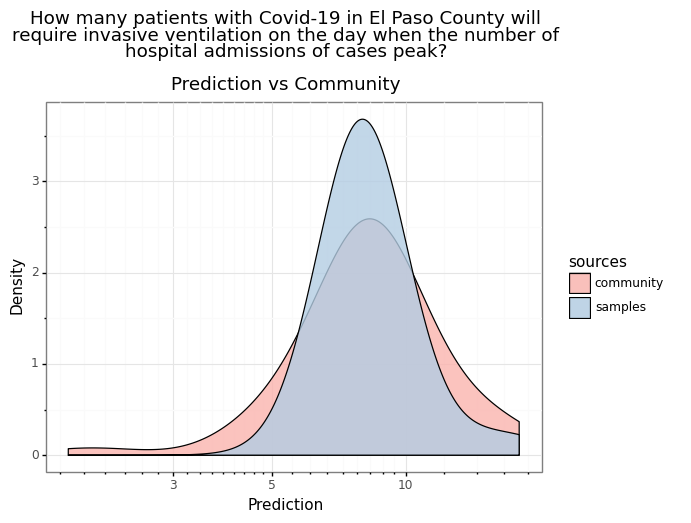

In [52]:
@question(4201)
def peak_invasive_ventilation():
    """
    How many patients with Covid-19 in El Paso County will be on invasive 
    ventilation on the day when the number of hospital admissions of cases 
    peak?
    """
    try:
        return get_historical_data(peak_hospitalized_date(), "on_ventilator")
    except KeyError:
        # If we don't have historical data,
        # use the community prediction...
        if ergo.flip(0.8):
            return peak_invasive_ventilation.question.sample_community()
        else:
            # ...or use @Tamay's approach:
            # https://pandemic.metaculus.com/questions/4201/#comment-28004
            return frac_icu_ventilation() * peak_icu_patients()
        

plot_question(peak_invasive_ventilation, bw=0.1)

# Generate predictions for all questions

In [19]:
def model():
    for sampler in samplers.values():
        sampler()

samples = ergo.run(model, num_samples=2000)

summarize_question_samples(samples)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,2000.0,33.06,24.38,25.0,25.00,25.00,25.00,174.00
peak_infections,2000.0,115.67,655.17,0.0,68.00,74.00,74.00,17630.71
mean_infections_peak345,2000.0,54.17,403.44,0.0,26.88,31.67,31.67,12892.19
mean_infections_peak678,2000.0,67.51,482.11,0.0,20.99,24.67,27.63,13280.32
frac_patients_icu,2000.0,0.30,0.10,0.0,0.23,0.29,0.36,0.99
frac_patients_invasive,2000.0,0.15,0.06,0.0,0.11,0.15,0.19,0.51
max_30d_hospital_confirmed_for_peak,2000.0,300.86,2442.97,0.0,65.00,65.00,65.00,45455.73
peak_icu_patients,2000.0,33.58,205.33,0.0,27.00,27.00,27.00,8947.10
peak_invasive_ventilation,2000.0,13.86,111.62,0.0,8.00,8.00,8.30,4620.82


# Compare predictions to community

This takes a while since we're fitting a mixture of logistic distributions to our samples before visualizing (and submitting) them.
These may look a little different from the plots below the questions above, because we've taken more samples from the distribution and we're fitting logistic distributions so we can submit them to metaculus

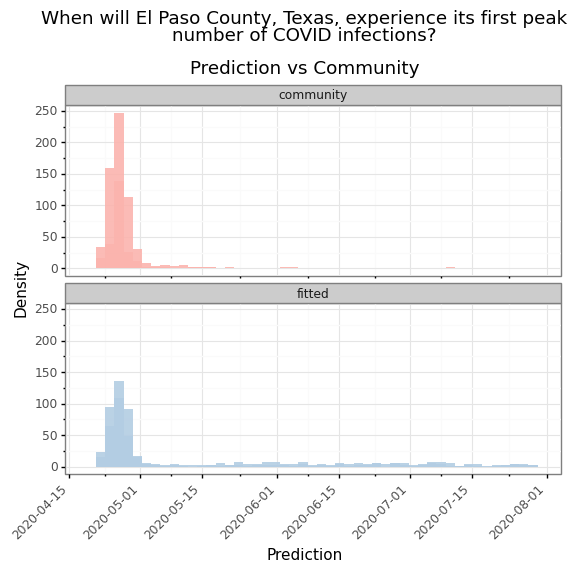

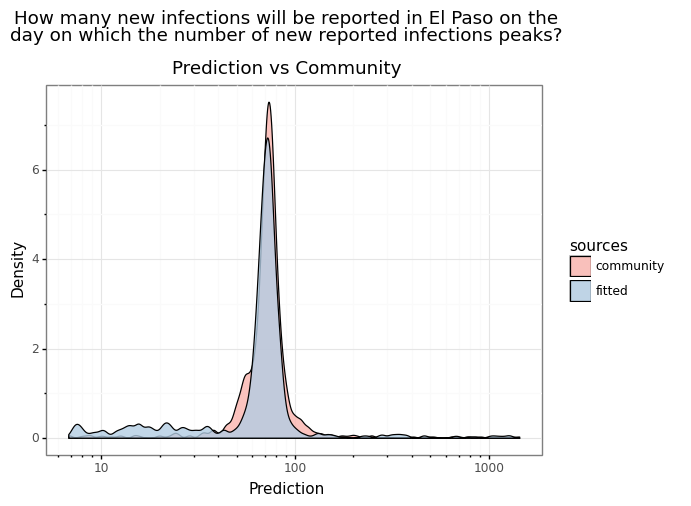

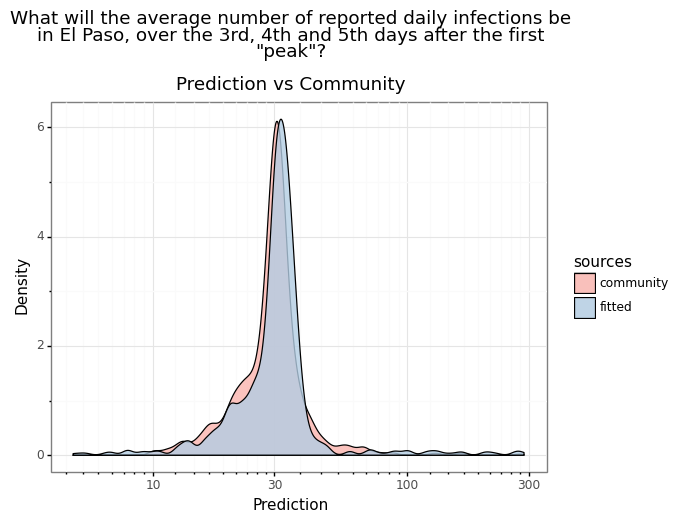

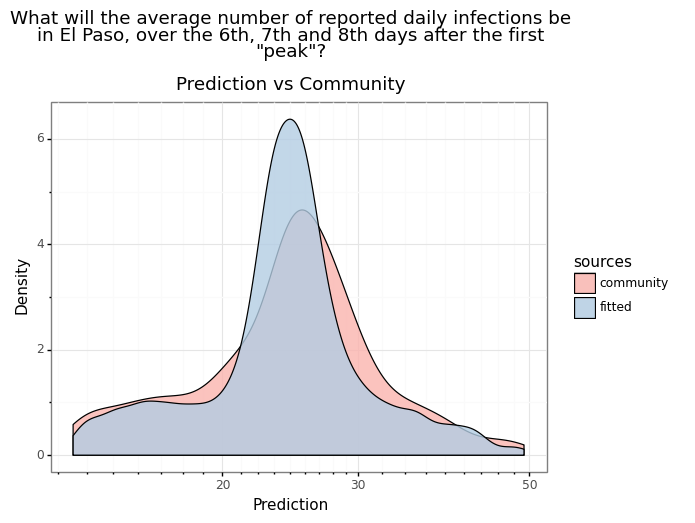

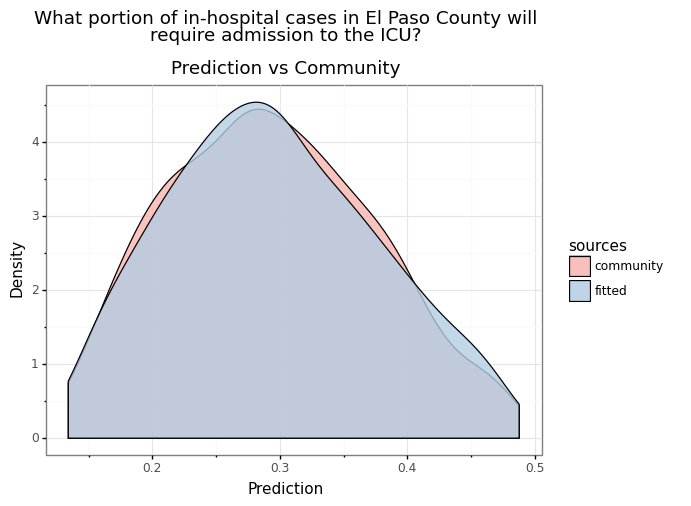

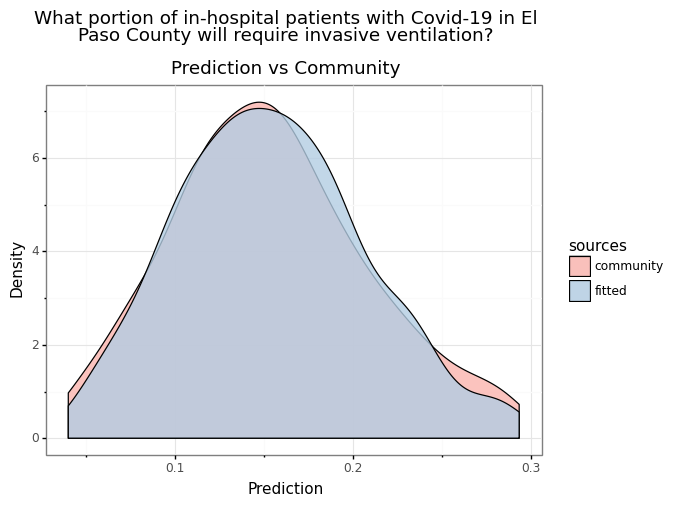

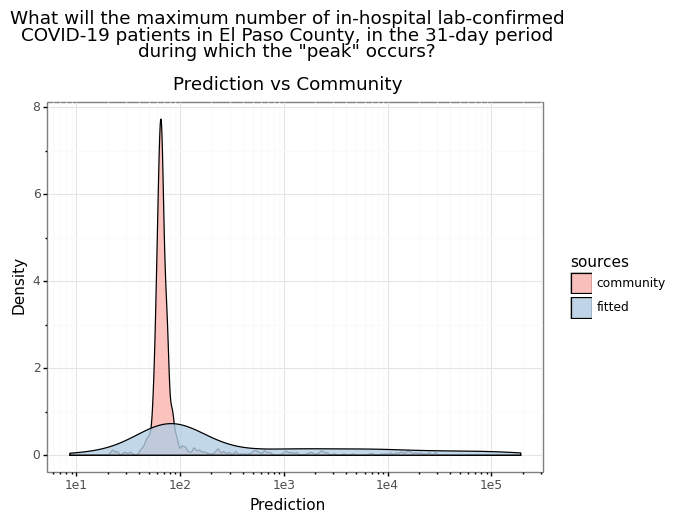

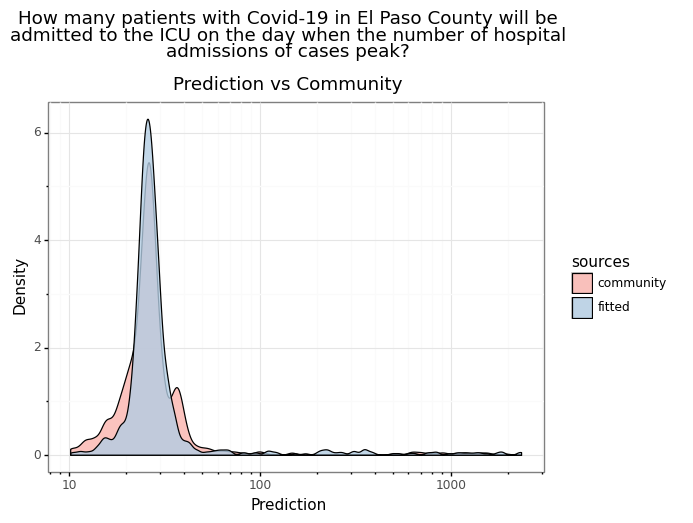

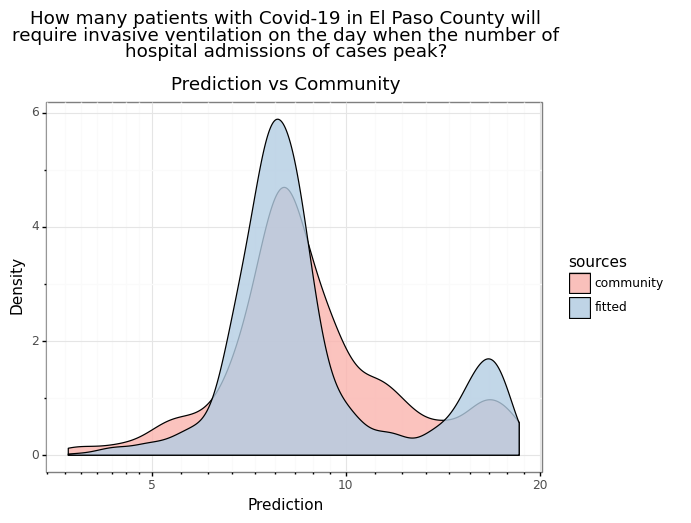

In [20]:
submissions = {}
for sampler in samplers.values():
    q = sampler.question

    q_samples = samples[sampler.__name__]

    if q.id == 4128: # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
        q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])

    if q.id in [4201, 4204, 4137, 4152, 4170, 4153]:
        # Clip extreme values for questions that we had issues fitting
        (sample_min, sample_max) = np.quantile(q_samples, [0.04, 0.96])
        q_samples = q_samples[(q_samples >= sample_min) & (q_samples <= sample_max)]

    submission = q.get_submission_from_samples(q_samples)
    submissions[q] = submission

    # the graph for this question will be too zoomed out unless we cut off more of the graph
    if q.id == 4153:
        q.show_prediction(q_samples, plot_samples=False, plot_fitted=True, show_community=True, percent_kept=0.7)
    else:
        q.show_prediction(q_samples, plot_samples=False, plot_fitted=True, show_community=True, percent_kept=0.9)

In [21]:
# Should we submit this to Metaculus? If so, uncomment the following lines:
# for q, submission in submissions.items():  
#     print(q.submit(submission))